# Data Story Exercise with scraped Yelp data of all Thai Restaurants in NYC

All Yelp pages for Thai Restaurants located in New York City were scraped and then parsed. The meta data for each restaurant was used for descriptive data analysis and visualization below.

In [26]:
#retrieve scraped Yelp data from hard drive
import pandas as pd
import os.path 
import csv
import matplotlib.pyplot as pyplot
import numpy as np
import ast
import itertools
import math
import re
from scipy.sparse import csr_matrix, hstack, vstack
from sklearn.feature_extraction import DictVectorizer

data_path = r'D:\Data Science\Springboard\yelp_metadata_v0_1.csv'
rest_df = pd.read_csv(data_path,  encoding = 'windows-1252')
yelp_meta_df = pd.read_csv(data_path, encoding = 'windows-1252')

path = r'D:\Data Science\yelp_data_v0_1.csv'
yelp_review_df = pd.read_csv(path, encoding = 'windows-1252')
rating = yelp_review_df['Reviewer Rating Clean']

dictionary_1 = {}
expected_cost = yelp_meta_df['Expected Cost'].fillna('n')


#create features for the dollar range
zero_dollars = []
one_dollars = []
two_dollars = []
three_dollars = []

for value in expected_cost:
    zero_dollars.append(0 if (len(value) == 0) else 0)
    one_dollars.append(1 if (len(value) == 1) else 0)
    two_dollars.append(2 if (len(value) == 2) else 0)
    three_dollars .append(3 if (len(value) == 3) else 0)

dictionary_1['zero dollars'] = zero_dollars
dictionary_1['$'] = one_dollars
dictionary_1['$$'] = two_dollars
dictionary_1['$$$'] = three_dollars
dictionary_1.pop('zero dollars')

#create features for the cuisine
cuisines = yelp_meta_df['Cuisines']
cuisine_list = [ast.literal_eval(x) for x in cuisines]
list_cuisine = itertools.chain.from_iterable(cuisine_list)
mylist = list(set(list_cuisine))


#initialize dictionary and then create empty dictionaries
dictionary = {}
for cuisine in mylist:
    dictionary.setdefault(cuisine, [])

# for each_cuisine in temp_dict:
for review in cuisine_list:
    for cuisine_type in review:
        dictionary[cuisine_type].append(1)
        
    temp_list = set(mylist) - set(review) #create a remainder list of values
    
    for cuisine_type in temp_list:
        dictionary[cuisine_type].append(0)


#create features for alcohol
dictionary_2 = {}
alcohol = yelp_meta_df['Alcohol'].fillna('Missing_1')
unique_alcohol_list = set(alcohol)

for alcohol_status in unique_alcohol_list:
    dictionary_2.setdefault(alcohol_status, [])

for index, value in enumerate(alcohol):
    if value  == 'Full Bar':
        temp_list = unique_alcohol_list - set([value])
        dictionary_2['Full Bar'].append(1)
        for value in temp_list:
            dictionary_2[value].append(0)
               
    elif value  == 'Missing_1':
        temp_list = unique_alcohol_list - set([value])
        dictionary_2['Missing_1'].append(1)
        for value in temp_list:
            dictionary_2[value].append(0)
        
    elif value  == 'Beer & Wine Only':
        temp_list = unique_alcohol_list - set([value])
        dictionary_2['Beer & Wine Only'].append(1)
        for value in temp_list:
            dictionary_2[value].append(0)
        
    elif value  == 'No':
        temp_list = unique_alcohol_list - set([value])
        dictionary_2['No'].append(1)
        for value in temp_list:
            dictionary_2[value].append(0)
        
dictionary_2['No Alcohol'] = dictionary_2.pop('No')

#create features for ambience
dictionary_3 = {}
ambience = yelp_meta_df['Ambience'].fillna('Missing_2')
unique_ambience_list = set(['Casual', 'Trendy', 'Hipster', 'Divey', 'Romantic', 'Classy', 'Intimate', 'Missing_2'])

for ambience_type in unique_ambience_list:
    dictionary_3.setdefault(ambience_type, [])

for index, value in enumerate(ambience):
    temp_list = unique_ambience_list #initialize a temporary list
    for ambience_type in unique_ambience_list:
        if re.search(ambience_type, value) != None:
            p = re.search(ambience_type, value).group(0)  
            dictionary_3[p].append(1)
            temp_list = temp_list - set([p])
    for remaining_ambience in temp_list:
        dictionary_3[remaining_ambience].append(0)
dictionary_3.pop('Missing_2')
        
#create features for Good for Groups
dictionary_4 = {}
g4g = yelp_meta_df['Good for Groups'].fillna('Missing_3')

dictionary_4.setdefault('Good for Group', [])

for index, value in enumerate(g4g):
    if value  == 'Yes':
        dictionary_4['Good for Group'].append(1)
    else:
        dictionary_4['Good for Group'].append(0)
             
#create features for Noise Level
dictionary_5 = {}
noise_level = yelp_meta_df['Noise Level'].fillna('Missing_4')
noise_level_list = set(noise_level)

for noise_type in noise_level_list:
    dictionary_5.setdefault(noise_type, [])

for noise_type in noise_level:
    temp_list = noise_level_list - set([noise_type]) #create a remainder list of values
    dictionary_5[noise_type].append(1)
    for other_noise_type in temp_list:
        dictionary_5[other_noise_type].append(0)
dictionary_5.pop('Missing_4')

combined_dict = {dictionary, **dictionary_1, **dictionary_2, **dictionary_3, **dictionary_4, **dictionary_5}

#compiling meta feature names and adding the meta tag at the end
combined_df_names = np.array(pd.DataFrame(combined_dict).columns.values)
for index, value in enumerate(combined_df_names):
    combined_df_names[index] += '_meta'

combined_df_values = pd.DataFrame(combined_dict)
print(combined_df_values.head(5))

   $  $$  $$$  Average  Beer & Wine Only  Casual  Classy  Divey  Full Bar  \
0  0   2    0        0                 0       0       0      0         1   
1  0   2    0        1                 1       1       0      0         0   
2  1   0    0        0                 0       0       0      0         0   
3  0   2    0        0                 1       1       0      0         0   
4  0   2    0        1                 0       0       0      0         0   

   Good for Group  Hipster  Intimate  Loud  Missing_1  No Alcohol  Quiet  \
0               1        0         0     0          0           0      1   
1               1        0         0     0          0           0      0   
2               0        0         0     0          0           1      0   
3               1        0         0     0          0           0      1   
4               0        0         0     0          0           1      0   

   Romantic  Trendy  Very Loud  
0         0       0          0  
1         0   

# What is the distribution of ratings across NYC Thai restaurants? 

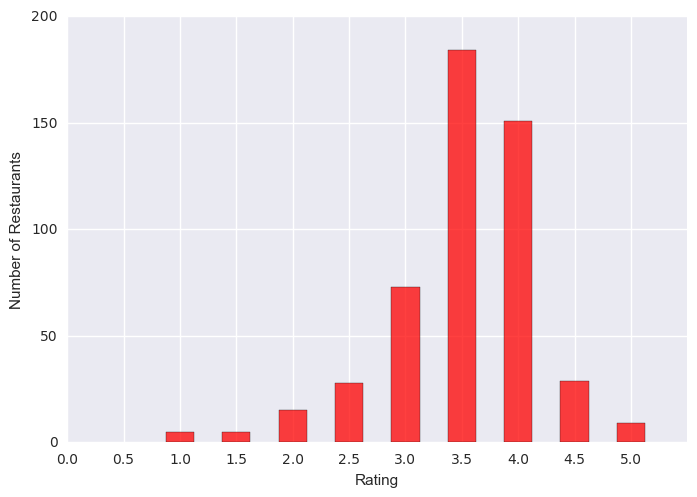

Average rating: Clean Rating    3.517034
dtype: float64
Average Rating Standard Deviation: Clean Rating    0.661124
dtype: float64


In [139]:
y = rest_df[['Clean Rating']]
series1 = y.iloc[:,0].dropna()

bin = np.arange(0,5.5,.5) + .25
pyplot.hist(series1, facecolor = 'red', alpha=.75, rwidth = .5, bins = bin)
pyplot.xlabel('Rating')
pyplot.ylabel('Number of Restaurants')
pyplot.xticks(np.arange(0,5.5,.5))
pyplot.xlim([0,5.5])
pyplot.show()

#calculate mean and standard deviation of ratings received by Thai restaurants in NYC
avg, std = np.mean(y), np.std(y)
print('Average rating:', avg)
print('Average Rating Standard Deviation:', std)

# What is the distribution of ratings across reviews written for all Thai restaurants in NYC? 

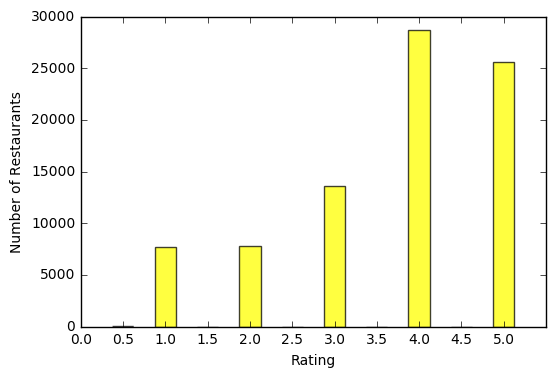

Average rating: 3.679764361472381
Average Rating Standard Deviation: 1.2543995167684066


In [30]:
y = rating.dropna()
# print(y)
# series1 = y.iloc[:,0].dropna()

bin = np.arange(0,5.5,.5) + .25
pyplot.hist(y, facecolor = 'yellow', alpha=.75, rwidth = .5, bins = bin)
pyplot.xlabel('Rating')
pyplot.ylabel('Number of Reviews')
pyplot.xticks(np.arange(0,5.5,.5))
pyplot.xlim([0,5.5])
pyplot.show()

#calculate mean and standard deviation of ratings received by Thai restaurants in NYC
avg, std = np.mean(y), np.std(y)
print('Average rating:', avg)
print('Average Rating Standard Deviation:', std)


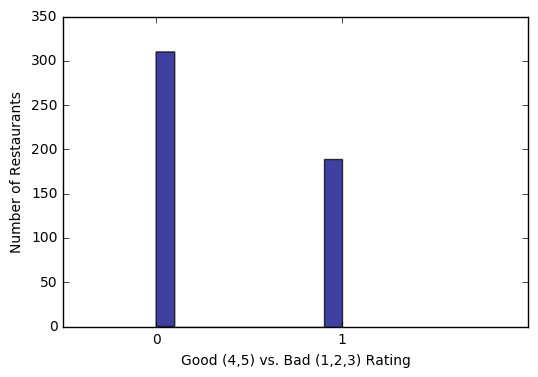

In [24]:
y = rest_df[['Clean Rating']]
y = y.iloc[:,0].dropna()

new_y = []
for rest_rating in y:
    new_y.append(int(1) if rest_rating >= 4 else int(0))

pyplot.hist(new_y, facecolor = 'navy', alpha=.75, rwidth = 3)
pyplot.xlabel('Good (4,5) vs. Bad (1,2,3) Rating')
pyplot.ylabel('Number of Restaurants')
pyplot.xticks(np.arange(-1, 2, 1))
pyplot.xlim([-.5,2])
pyplot.show()


# What is the distribution of ratings across all NYC Thai restaurants with different costs?

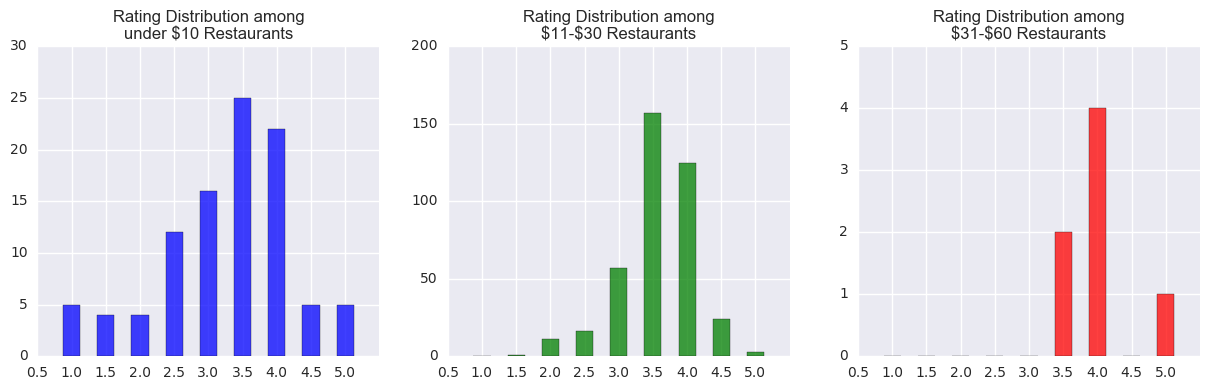

In [216]:
import matplotlib.pyplot as plt
import textwrap

y = rest_df['Clean Rating']
cheap = combined_df_values['$']
moderate = combined_df_values['$$']
expensive = combined_df_values['$$$']


one_dollar_rest = []
for index, value in enumerate(cheap):
    if value > 0:
        one_dollar_rest.append(y[index])
one_dollar_rest = [x for x in one_dollar_rest if str(x) != 'nan']

two_dollar_rest = []
for index, value in enumerate(moderate):
    if value > 0:
        two_dollar_rest.append(y[index])
two_dollar_rest = [x for x in two_dollar_rest if str(x) != 'nan']

three_dollar_rest = []
for index, value in enumerate(expensive):
    if value > 0:
        three_dollar_rest.append(y[index])
three_dollar_rest = [x for x in three_dollar_rest if str(x) != 'nan']

fig, axes = plt.subplots(1, 3, figsize=(15, 4))
axes[0].hist(one_dollar_rest, facecolor = 'blue', alpha=.75, rwidth = .5, bins = bin)
axes[0].set_title(textwrap.fill('Rating Distribution among under $10 Restaurants',27))
axes[0].set_ylim([0, 30])
axes[0].set_xlim([.5,5.5])
axes[0].set_xticks(np.arange(.5,5.5,.5))

axes[1].hist(two_dollar_rest, facecolor = 'green', alpha=.75, rwidth = .5, bins = bin)
axes[1].set_title(textwrap.fill('Rating Distribution among \$11-\$30 Restaurants',27))
axes[1].set_ylim([0, 200])
axes[1].set_xlim([.5,5.5])
axes[1].set_xticks(np.arange(.5,5.5,.5))

axes[2].hist(three_dollar_rest, facecolor = 'red', alpha=.75, rwidth = .5, bins = bin)
axes[2].set_title(textwrap.fill('Rating Distribution among \$31-\$60 Restaurants',27))
axes[2].set_ylim([0, 5])
axes[2].set_xlim([.5,5.5])
axes[2].set_xticks(np.arange(.5,5.5,.5))
plt.show()

# What is the distribution of ratings across all NYC Thai restaurants that do and don't serve alcohol?

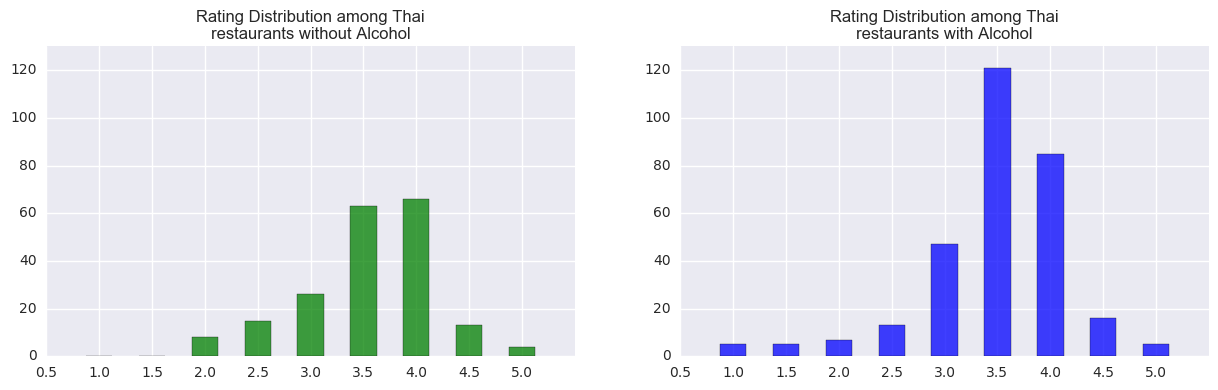

In [220]:
alcohol = combined_df_values['No Alcohol']

has_alcohol = []
no_alcohol = []
for index, restaurant in enumerate(alcohol):
    if restaurant > 0:
        no_alcohol.append(y[index])
    else:
        has_alcohol.append(y[index])
 
has_alcohol = [x for x in has_alcohol if str(x) != 'nan']
no_alcohol = [x for x in no_alcohol if str(x) != 'nan']

fig, axes = plt.subplots(1, 2, figsize=(15, 4))

axes[0].hist(no_alcohol, facecolor = 'green', alpha=.75, rwidth = .5, bins = bin)
axes[0].set_title(textwrap.fill('Rating Distribution among Thai restaurants without Alcohol',30))
axes[0].set_ylim([0, 130])
axes[0].set_xlim([.5,5.5])
axes[0].set_xticks(np.arange(.5,5.5,.5))

axes[1].hist(has_alcohol, facecolor = 'blue', alpha=.75, rwidth = .5, bins = bin)
axes[1].set_title(textwrap.fill('Rating Distribution among Thai restaurants with Alcohol',30))
axes[1].set_ylim([0, 130])
axes[1].set_xlim([.5,5.5])
axes[1].set_xticks(np.arange(.5,5.5,.5))

plt.show()

# Do restaurants representing more than one cuisine typically have higher ratings?

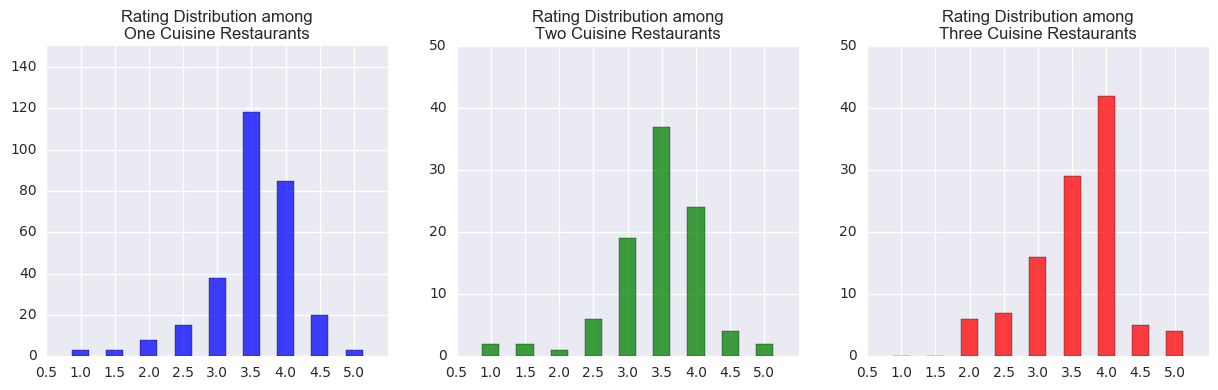

In [199]:
import ast
import pandas
import matplotlib.pyplot as plt

cuisine_pop_rest = rest_df['Cuisines']

y_series = y.iloc[:, 0]
cuisine_pop_rest = [len(ast.literal_eval(x)) for x in cuisine_pop_rest]
one_cuisine = []
two_cuisine = []
three_cuisine = []

for index, restaurant in enumerate(np.array(cuisine_pop_rest)):
    
    if restaurant == 1:
        one_cuisine.append(y_series[index])
        
    elif restaurant == 2:
        two_cuisine.append(y_series[index])
    elif restaurant == 3:
        three_cuisine.append(y_series[index])
        
one_cuisine = [x for x in one_cuisine if str(x) != 'nan']
two_cuisine = [x for x in two_cuisine if str(x) != 'nan']
three_cuisine = [x for x in three_cuisine if str(x) != 'nan']

fig, axes = plt.subplots(1, 3, figsize=(15, 4))
axes[0].hist(one_cuisine, facecolor = 'blue', alpha=.75, rwidth = .5, bins = bin)
axes[0].set_title(textwrap.fill('Rating Distribution among One Cuisine Restaurants',27))
axes[0].set_ylim([0, 150])
axes[0].set_xlim([.5,5.5])
axes[0].set_xticks(np.arange(.5,5.5,.5))

axes[1].hist(two_cuisine, facecolor = 'green', alpha=.75, rwidth = .5, bins = bin)
axes[1].set_title(textwrap.fill('Rating Distribution among Two Cuisine Restaurants',27))
axes[1].set_ylim([0, 50])
axes[1].set_xlim([.5,5.5])
axes[1].set_xticks(np.arange(.5,5.5,.5))

axes[2].hist(three_cuisine, facecolor = 'red', alpha=.75, rwidth = .5, bins = bin)
axes[2].set_title(textwrap.fill('Rating Distribution among Three Cuisine Restaurants',27))
axes[2].set_ylim([0, 50])
axes[2].set_xlim([.5,5.5])
axes[2].set_xticks(np.arange(.5,5.5,.5))

plt.show()

KEY INSIGHTS:
1. Most restaurants that received over 500 reviews served only Thai food.
2. However, most restaurants that did cater to more than one Cuisine chose to represent 3 cuisines rather than 2. 


ADDITIONAL CONSIDERATIONS:

    For restaurants that represent more than 1 cuisine, should their revivews be weighted less because they don't represent purely Thai cuisine? 
    
    What other factors might affect the number of reviews a restaurant might receive? (e.g. is the location of the restaurant a major factor to consider?)
   

Clean Rating    3.517034
dtype: float64
Clean Rating    0.661124
dtype: float64


KEY INSIGHTS: 
1. The average Thai restaurant in NYC received a rating of 3.5. 
2. From the histogram, most Thai restaurants in NYC received a rating of 3.5 or 4.0.

CONSIDERATIONS:

    Given that the average Thai restaurant in NYC received a rating of 3.5, does this imply that most Thai restaurants in NYC are above the average (above a 3.0 rating)? Or is Thai cuisine (as a whole) generally rated higher and more liked by NYC residents when compared to other cuisines? 

    If 3.5 is the "true" average for Thai food in NYC, should we consider recalibrating the average for Thai restaurants to 3.5 (instead of 3.0) to truly discover elite Thai food? 

# How many reviews do restaurants that receive a rating of 4 stars or higher typically get?

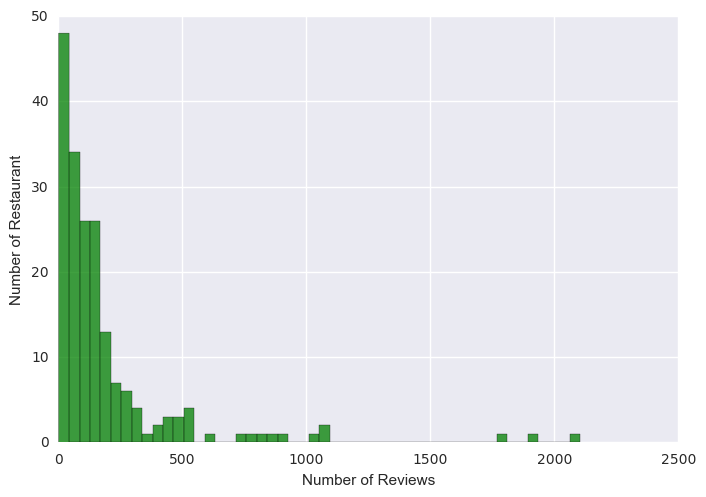

In [200]:
#Histogram 
import matplotlib.pyplot as pyplot
from scipy.stats import stats
import numpy as np

good_restaurant = rest_df[rest_df['Clean Rating'] >= 4]
good_restaurant_review_count = sorted(good_restaurant['Review Count Num'])

pyplot.hist(good_restaurant_review_count, facecolor = 'green', alpha=.75, bins = 50)
pyplot.xlabel('Number of Reviews')
pyplot.ylabel('Number of Restaurant')
pyplot.show()


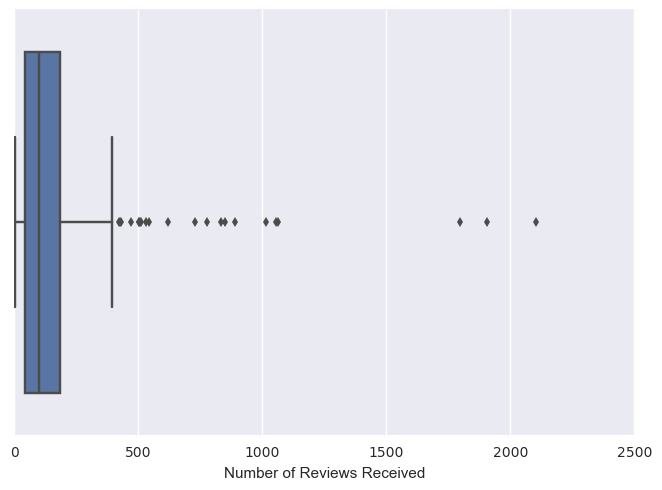

189 190.238095238 298.47370366


In [211]:
#Box and Whisker Plot
import seaborn as sns

sns.boxplot(good_restaurant_review_count)

pyplot.xlabel('Number of Reviews Received')
plt.show()

mean = np.mean(good_restaurant_review_count)
std = np.std(good_restaurant_review_count)
count = len(good_restaurant_review_count)
print(count, mean, std)

KEY INSIGHTS:
1. Thai restaurants rated 3.5 stars or higher, on average, receive 193 reviews.
2. As expected, most restaurants have not received more than 500 reviews and we observe the majority of restaurants below 250 reviews. 

CONSIDERATIONS:

    Should restaurants that receive a 5.0/5.0 rating be given less credit because they'eve received less reviews?  
    
    How does this graph represent restaurants who may have improved their restaurant ratings over time? I beleive that restaurants that have improved their ratings over time will average out to a 3.5 or 4.0, but will find much difficulty in ever reaching a 4.5 rating. 

   
   

# Do restaurants that receive more reviews generally receive higher ratings?

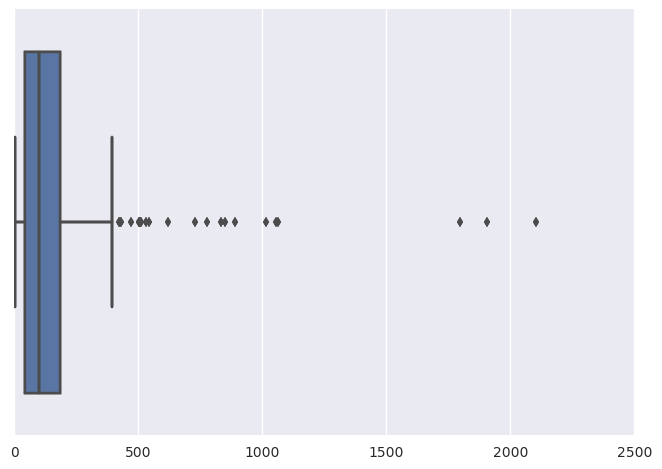

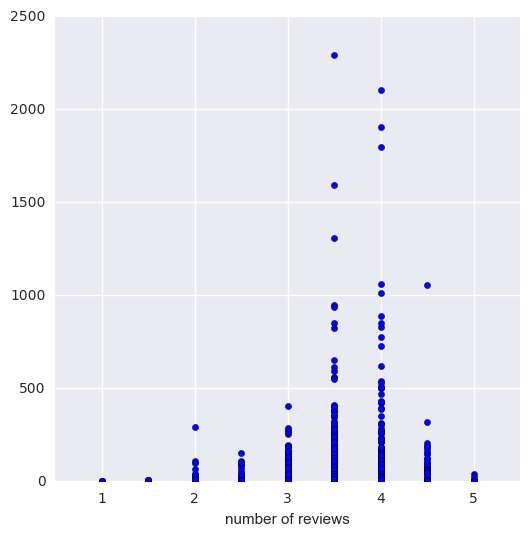

In [206]:
import pandas as pd
df1 = pd.DataFrame(rest_df['Review Count Num'])
df2 = pd.DataFrame(rest_df['Clean Rating'])

graph_df = pd.concat([df1,df2],axis = 1).dropna()
x = graph_df[['Review Count Num']]
y = graph_df[['Clean Rating']]

import matplotlib.pyplot as pyplot

fig,axes = pyplot.subplots(figsize=(6,6))
axes.scatter(y,x,)
pyplot.xlabel('rating')
pyplot.ylabel('number of reviews')
axes.set_ylim([0,2500])
axes.set_xlim([.5,5.5])
pyplot.show()

KEY INSIGHTS:
1. Restaurants that receive over 500 reviews always receive ratings of 3.5 or higher!
2. Restuarants that receive a 5.0/5.0 rating have a significantly lower review count when compared to restaurants rated 4.5 or lower. 

CONSIDERATIONS:

    Should restaurants that receive a 5.0/5.0 rating be given less credit because they'eve received less reviews?  
    
    How does this graph represent restaurants who may have improved their restaurant ratings over time? I beleive that restaurants that have improved their ratings over time will average out to a 3.5 or 4.0.
   
   